In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
nyc = pd.read_excel("nyc_crime_data.xls", header=0)  #manually removed the first 4 rows in the excel file containing metadata

In [3]:
nyc.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.000,0.000,0.000,nan,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,nan,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000
2,Akron Village,2846.000,3.000,0.000,nan,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000
3,Albany,97956.000,791.000,8.000,nan,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,nan
4,Albion Village,6388.000,23.000,0.000,nan,3.000,4.000,16.000,223.000,53.000,165.000,5.000,nan


In [4]:
# data rename 
nyc = nyc.rename(index=str, columns={'City': 'city', 'Population': 'population', 'Violent\ncrime': 'violent_crime',
       'Murder and\nnonnegligent\nmanslaughter' : 'murder_manslaughter',
       'Rape\n(legacy\ndefinition)2': 'rape',
       'Robbery': 'robbery_default', 'Aggravated\nassault': 'aggr_assault', 
        'Property\ncrime': 'property_crime', 'Burglary':'burglary',
       'Larceny-\ntheft': 'larceny_theft', 'Motor\nvehicle\ntheft': 'motor_theft'})

In [5]:
# Creating suggested feaures 

#nyc['pop_sqr'] = nyc.population**2
#nyc['murder'] = np.where(nyc['murder_manslaughter'] > 0,1,0)
#nyc['robbery_cat'] = np.where(nyc.robbery_default > 0, 1, 0)
#
# Deleting rape 1 column as all nan
nyc = nyc.drop(columns = ['Rape\n(revised\ndefinition)1'])


In [6]:
# Basic data cleaning 
nyc.describe()

,population,violent_crime,murder_manslaughter,rape,robbery_default,aggr_assault,property_crime,burglary,larceny_theft,motor_theft,Arson3
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,187.000
mean,40037.632,201.595,1.566,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.872
std,450037.368,2815.269,18.304,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,10.693
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,0.000,1.000,4.000,112.500,17.500,94.000,2.000,0.000
75%,18427.500,22.000,0.000,2.000,5.000,14.000,341.000,51.250,287.250,7.000,1.000
max,8396126.000,52384.000,335.000,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000


In [7]:
print(nyc.isnull().sum())   # list of NaNs 

nyc[nyc.city.str.contains('The')]
# index 348-350 . # the last three rows

nyc = nyc[:-3]

city                     0
population               3
violent_crime            3
murder_manslaughter      3
rape                     3
robbery_default          3
aggr_assault             3
property_crime           3
burglary                 3
larceny_theft            3
motor_theft              3
Arson3                 164
dtype: int64


In [8]:
#print(nyc.isnull().sum())  #nyc.isna().sum()  No null values except for Asson3 (161)

In [9]:
nyc.columns

Index(['city', 'population', 'violent_crime', 'murder_manslaughter', 'rape',
       'robbery_default', 'aggr_assault', 'property_crime', 'burglary',
       'larceny_theft', 'motor_theft', 'Arson3'],
      dtype='object')

(0, 800)

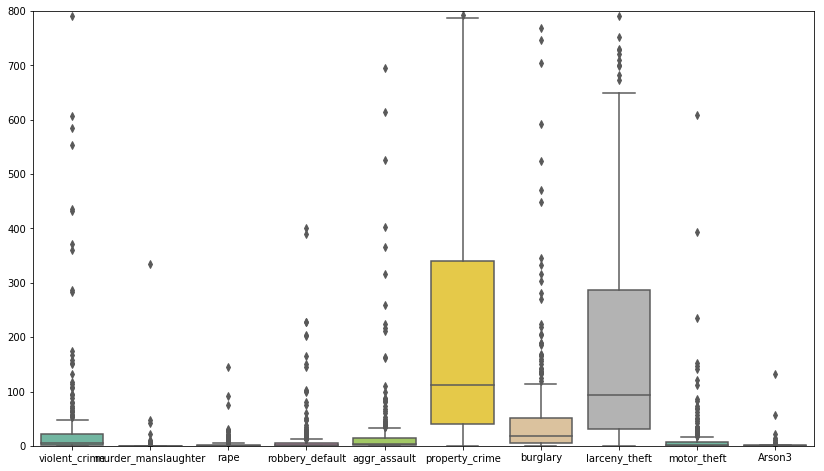

In [10]:
plt.figure(figsize=(14,8))
sns.boxplot(data=nyc[[ 'violent_crime', 'murder_manslaughter', 'rape',
       'robbery_default', 'aggr_assault', 'property_crime', 'burglary',
       'larceny_theft', 'motor_theft', 'Arson3']], palette="Set2" )

#plt.ylim(0,5000)  #default shows few (6 in number) outliers after 5000
#plt.ylim(0,1000)  #default shows few outliers after 1000

plt.ylim(0,800)  #almost all values of these variables are concentrated under 500

# Among the variables 'property_Crime' is the quite frequent 

(0, 120)

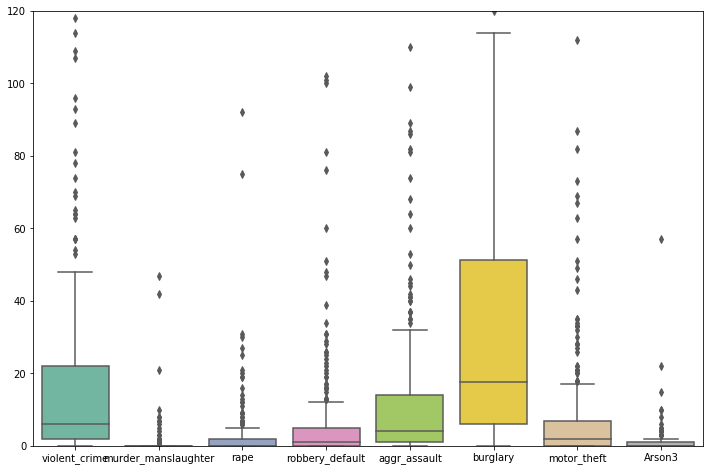

In [11]:
# Taking a closer look at the variables

plt.figure(figsize=(12,8))
sns.boxplot(data=nyc[[ 'violent_crime', 'murder_manslaughter', 'rape',
       'robbery_default', 'aggr_assault', 'burglary',
       'motor_theft', 'Arson3']], palette="Set2" )

plt.ylim(0, 120)  #rest of the crimes are contained within 120 occurrences

In [12]:
# creating features - city to boroughs -- didn't find appropriate documentation - http://www.nysl.nysed.gov/genealogy/townlist.htm
#this doesn't have all names. 

In [13]:
#nyc.iloc[np.where(nyc.pop_sqr == nyc.pop_sqr.max())]  # NYC is the source for all outliers

According to the FBI's Uniform Crime Reporting [(here)](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/property-crime/property-crime-topic-page/propertycrimemain_final), property crime includes the offenses of burglary, larceny-theft, motor vehicle theft, and arson. The object of the theft-type offenses is the taking of money or property, but there is no force or threat of force against the victims. The property crime category includes arson because the offense involves the destruction of property; however, arson victims may be subjected to force. Therefore, it is expected that the property crime will be highly correlated with these variables. 

Multiple Linear Regression formula:

$$ property crime = \alpha + burglary + larceny/theft + motor theft + arson $$

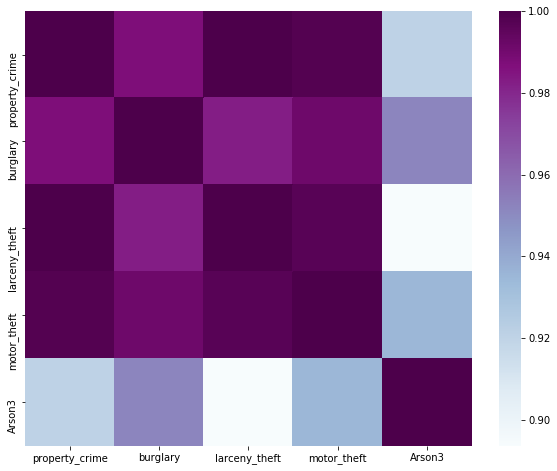

                property_crime  burglary  larceny_theft  motor_theft  Arson3
property_crime           1.000     0.987          1.000        0.998   0.921
burglary                 0.987     1.000          0.983        0.991   0.952
larceny_theft            1.000     0.983          1.000        0.997   0.894
motor_theft              0.998     0.991          0.997        1.000   0.935
Arson3                   0.921     0.952          0.894        0.935   1.000


In [14]:
corr = nyc[['property_crime','burglary', 'larceny_theft', 'motor_theft', 'Arson3']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='BuPu', linecolor='white')
plt.show()
print(corr)


As expected, property crime is highly correlated with larceny and theft, however, it is not corelated with arson. 

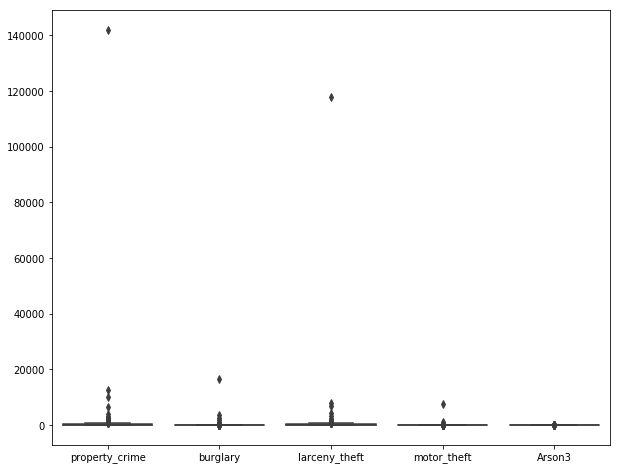

In [15]:
plt.figure(figsize=(10,8))
sns.boxplot(data=nyc[['property_crime','burglary', 'larceny_theft', 'motor_theft', 'Arson3']])


In [16]:
# Data cleaning: All the variables have outliers. 

#isolation forest filter - sklearn 

# Winsorizing the outliers. Outliers in the both ends are substituted with a quantile value given by the function 
# The (limits[0])th lowest values are set to the (limits[0])th percentile, and the (limits[1])th highest values are set to the (limits[1])th percentile. 
from scipy import stats

nyc[['property_crime','burglary', 'larceny_theft', 'motor_theft', 'Arson3']]

import scipy

nyc['property_crime'] = scipy.stats.mstats.winsorize(nyc['property_crime'], limits=[0,0.03])
nyc['burglary'] = scipy.stats.mstats.winsorize(nyc['burglary'], limits=[0,0.03])
nyc['larceny_theft'] = scipy.stats.mstats.winsorize(nyc['larceny_theft'], limits=[0,0.03])
nyc['motor_theft'] = scipy.stats.mstats.winsorize(nyc['motor_theft'], limits=[0,0.03])
nyc['Arson3'] = scipy.stats.mstats.winsorize(nyc['Arson3'], limits=[0,0.03])


(0, 900)

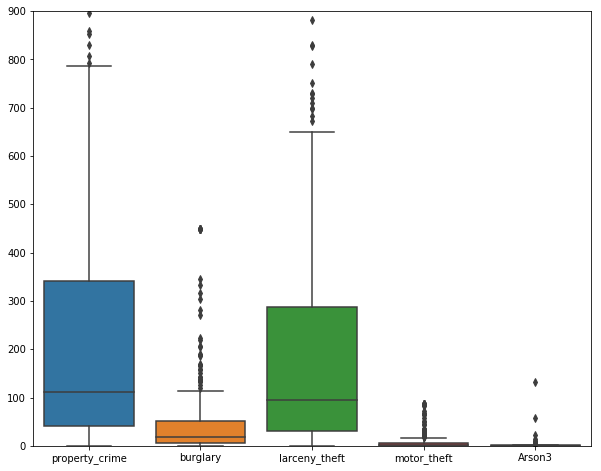

In [17]:
plt.figure(figsize=(10,8))

#sns.subplot(3,2,1)
sns.boxplot(data=nyc[['property_crime','burglary', 'larceny_theft', 'motor_theft', 'Arson3']]) #, orient='h')
plt.ylim(0,900)

In [18]:
# Instantiate and fit the first version of the model.
regr = linear_model.LinearRegression()
Y = nyc.property_crime.values.reshape(-1,1)
X = nyc[['burglary', 'larceny_theft', 'motor_theft']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))



Coeffiicients: 
 [[1.03514399 0.98774906 1.07249876]]

Intercept: 
 [0.88265]

R-squared:
0.9989995532674184


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Most likely such a high R-squared value is indicative of model overfitting, but as we will see in this model(?) /exercise, the chosen parameters are in fact explaining most of the variances of the model. 

Checking the accuracy of the model with cross-validation as what this does is to make 10-fold training and testing set in the during model training and testing, and returns the accuracies. The mean accuracy via cross-validation is a more validated indicator of the accuracy. 


In [19]:
# Adding cross-validation 

from sklearn.model_selection import cross_val_score

regr = linear_model.LinearRegression()

print(cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())

[0.99918433 0.99939991 0.99997552 0.99948924 0.99970378 0.99894265
 0.99905906 0.99936564 0.99893903 0.99595589]
Mean CV score:  0.9990015035816853


For an initial observation, this model looks __definitely overfitted__ as the r-squared value is 0.99. 

In [20]:
# Removing Arson as not much data

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = nyc.property_crime.values.reshape(-1,1)
X = nyc[['burglary', 'larceny_theft', 'motor_theft']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))

print("10-k cross validation scores: \n", cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())



Coeffiicients: 
 [[1.03514399 0.98774906 1.07249876]]

Intercept: 
 [0.88265]

R-squared:
0.9989995532674184
10-k cross validation scores: 
 [0.99918433 0.99939991 0.99997552 0.99948924 0.99970378 0.99894265
 0.99905906 0.99936564 0.99893903 0.99595589]
Mean CV score:  0.9990015035816853


In [21]:
# Adding robbery as one of the predictors, 
#R-squared a little less, meaning the robbery is adding more noise to the data 

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = nyc.property_crime.values.reshape(-1,1)
X = nyc[['burglary', 'larceny_theft', 'motor_theft', 'robbery_default']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))

print("10-k cross validation scores: \n", cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())



Coeffiicients: 
 [[ 1.04587122  0.98713788  1.09941301 -0.00401261]]

Intercept: 
 [0.54494744]

R-squared:
0.9990591890322064
10-k cross validation scores: 
 [0.99920263 0.99943715 0.99997152 0.99954118 0.99974746 0.99908223
 0.83294854 0.99931993 0.99875739 0.99615204]
Mean CV score:  0.9824160082654549


In [22]:
#X.columns -


In [23]:
# Checking with other variables, just to make sure if we are on the right path

In [24]:
nyc[['violent_crime', 'murder_manslaughter', 'rape', 'Arson3']].isnull().sum()
# arson has 161 null 

# Filling NaNs in Arson with mean of the column
nyc.Arson3.fillna(nyc.Arson3.mean(), inplace = True)

In [25]:
nyc[['violent_crime', 'murder_manslaughter', 'rape', 'Arson3']].isnull().sum()
# arson had 161 null values

violent_crime          0
murder_manslaughter    0
rape                   0
Arson3                 0
dtype: int64

In [26]:
regr = linear_model.LinearRegression()
Y = nyc.property_crime
X = nyc[['violent_crime', 'murder_manslaughter', 'rape', 'Arson3']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))  # the R^2 is .99. This is probably still overfitting. 

print("10-k cross validation scores: \n", cross_val_score(regr, X, Y, cv=10))  #r-squared 

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())



Coeffiicients: 
 [  -0.71726311 -122.2716077    72.63425885   18.96695486]

Intercept: 
 193.69603476359364

R-squared:
0.4380961973105269
10-k cross validation scores: 
 [ 4.17701464e-01  2.12491115e-01  8.12071567e-02  3.33530047e-01
 -1.87170004e+00  1.81137783e-01 -7.41728449e+02 -2.17915415e-03
  5.97945944e-01  3.76365374e-01]
Mean CV score:  -74.14019492095534


In [27]:
# Checking -CV R2 results manually 

actual = Y
predict = regr.predict(X)
residual = actual - predict

def r_sqr(actual, predict):
    residual = actual - predict
    u = (residual**2).sum()
    v = ((actual - actual.mean())**2).sum()
    print(u, v)
    print(1 - (u/v))  # r-squared
    
    

In [28]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
for train, test in kf.split(X):
    regr.fit(X.values[train], Y.values[train])   #accessing values as X is a dataframe
    y_pred = regr.predict(X.values[test])
    r_sqr(Y[test], y_pred)

# the u/v if the u is much larger than the v, the r^2, i.e., 1-u/v will be a large minus number (e.g., -741), and 
# this explains how the r-sqrdd and CV have - values

8158121.846019328 14010204.971428571
0.41770146385035556
11233062.877842667 14264045.885714287
0.21249111452362945
1447460.627628643 1575393.8857142858
0.08120715666459355
4912594.470298543 7371066.685714286
0.3335300466322545
11853636.881196415 4127742.0
-1.8717000435580555
2754710.6138432543 3364070.9714285713
0.18113778298991978
8611376856.983131 11594246.685714286
-741.7284488947038
7757266.264890465 7740398.742857143
-0.0021791541487299337
4165236.7857111315 10359892.470588233
0.5979459441749756
8984020.25944912 14405903.529411765
0.37636537402135695


Other uncorrelated variables decreases model accuracy. 

One final version with Arson as one of the explanatory variable. 

In [29]:
#  with arson. 

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = nyc.property_crime.values.reshape(-1,1)
X = nyc[['burglary', 'larceny_theft', 'motor_theft', 'Arson3']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))

print("10-k cross validation scores: \n", cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())

# This seems to have the highest cross-validation score 



Coeffiicients: 
 [[ 1.05134094  0.98728686  1.1199387  -0.65587491]]

Intercept: 
 [0.97967714]

R-squared:
0.9990828271644957
10-k cross validation scores: 
 [0.99919527 0.99935757 0.99995881 0.99957873 0.99978269 0.99920714
 0.99895414 0.99945396 0.9991174  0.99620632]
Mean CV score:  0.999081203439129


6.1200000000000045


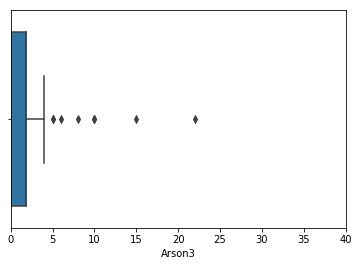

In [30]:
# Checking if arson has any outliers 

sns.boxplot(nyc.Arson3) #one outlier at 60 and another at 120
plt.xlim(0,40)
print(nyc.Arson3.quantile(.98))

nyc.Arson3 = stats.mstats.winsorize(nyc.Arson3, limits=(0, 0.03))

Let's now checking the linear relationship in the variables of interest for the purpose of checking the assumptions.  

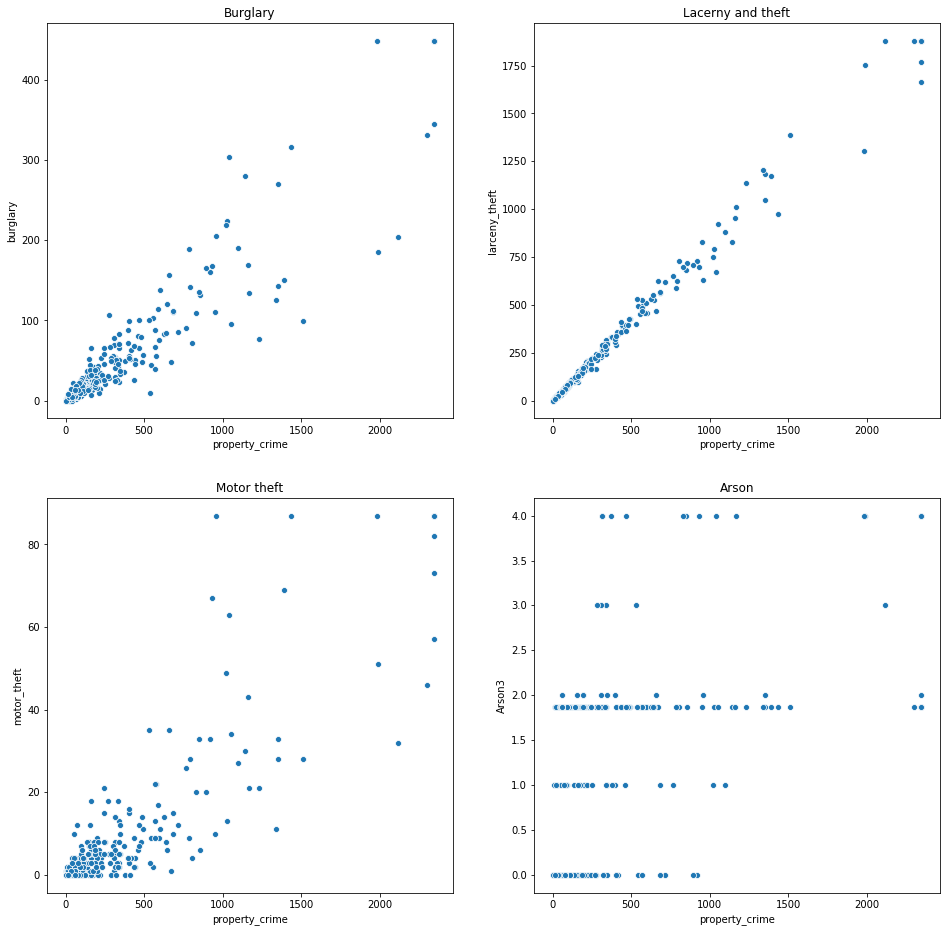

In [31]:
plt.figure(figsize=(16,16))


#'burglary', 'larceny_theft', 'motor_theft', 'Arson3'

#Burglary
plt.subplot(2, 2, 1)
sns.scatterplot(nyc.property_crime, nyc.burglary)
plt.title('Burglary')

#Lacerny
plt.subplot(2, 2, 2)
sns.scatterplot(nyc.property_crime, nyc.larceny_theft)
plt.title('Lacerny and theft')

# Motor theft
plt.subplot(2, 2, 3)
sns.scatterplot(nyc.property_crime, nyc.motor_theft)
plt.title('Motor theft')

# Arson
plt.subplot(2, 2, 4)
sns.scatterplot(nyc.property_crime, nyc.Arson3)
plt.title('Arson')
plt.show()

# NONE of the relationships are linear 
# For the first pop-pop_squared we can do a square_root 

#follow the following reference 

    

It seems almost all the relationships, except arson, are linear.  


[independent variable transformation](https://statswithcats.wordpress.com/2010/11/21/fifty-ways-to-fix-your-data)

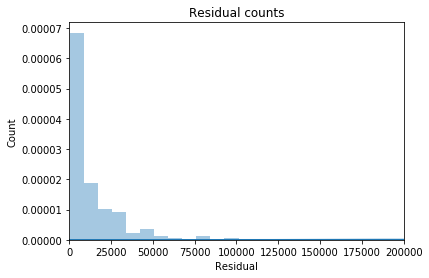

In [32]:
# check residual 

predicted = regr.predict(X).ravel()
actual = nyc.population

residual = actual - predicted

sns.distplot(residual, bins=1000)

#plt.hist(residual, bins=1000)
#plt.yscale('log')
#plt.xscale('log')
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim(0,200000)
plt.show()

# residual is not normally distributed and close to zero. 

# Most of the errors are reasonable but there are quire a few outliers 


In [33]:
residual.describe()

count       348.000
mean      39718.526
std      449899.838
min         520.084
25%        2947.878
50%        7078.687
75%       18072.318
max     8393702.636
Name: population, dtype: float64

In [34]:
# PCLS

# start with all variables and then apply PCLS 
# from this residual we see that there are some things that are not accounted for 


sns.distplot?

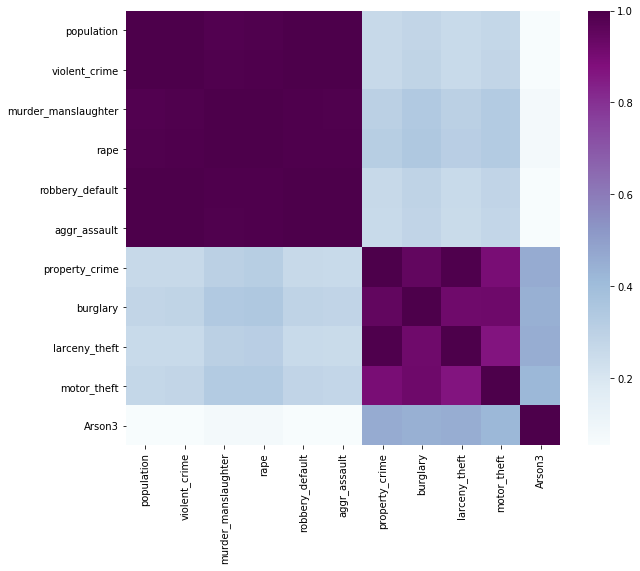

In [35]:
# Check multicollinearity 
plt.figure(figsize=(10,8))
sns.heatmap(nyc.corr(), cmap='BuPu', square=True)


This exercise shows the important effects of outliers in predicting the modes. The variables in the lower half of the corrplot had extreme high correlation. Now, after outlier removal, we have more information.

In [36]:
# Now try residual before and after cross validation

#from sklearn.model_selection import cross_val_predict
#predicted_cv = cross_val_predict(regr, X, Y).ravel()
#actual = nyc.population
#
#residual_cv = actual - predicted_cv
#
#plt.figure(figsize=(10,8))
#
#plt.subplot(1,2,1)
#sns.distplot(residual, bins=1000)
#plt.xlim(0,100000)
#plt.title("Residual before cross-validation")
#
#plt.subplot(1,2,2)
#sns.distplot(residual_cv, bins=1000)
#plt.title("Residual after cross-validation")
#plt.xlim(0,100000)
#plt.show()
#
# not much different

In [37]:
regr = linear_model.LinearRegression()
Y = nyc.property_crime.values.reshape(-1,1)
X = nyc[['burglary', 'larceny_theft', 'motor_theft']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))

print("10-k cross validation scores: \n", cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())


Coeffiicients: 
 [[1.03514399 0.98774906 1.07249876]]

Intercept: 
 [0.88265]

R-squared:
0.9989995532674184
10-k cross validation scores: 
 [0.99918433 0.99939991 0.99997552 0.99948924 0.99970378 0.99894265
 0.99905906 0.99936564 0.99893903 0.99595589]
Mean CV score:  0.9990015035816853


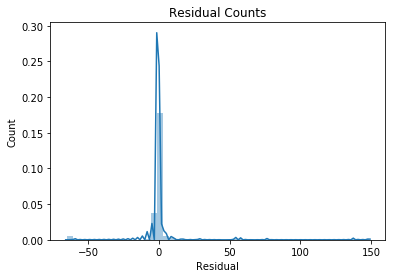

In [38]:
# prediction 

predicted  = regr.predict(X).ravel()
actual= nyc.property_crime

residual = actual - predicted

sns.distplot(residual, bins=50)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

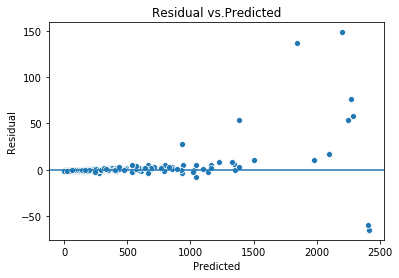

In [39]:
sns.scatterplot(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs.Predicted')
plt.show()

It seems like a pretty good fit! 

Earlier, our regression formula was: 

$$ property crime = \alpha + burglary + larceny/theft + motor theft + arson $$

Now, modifying the formula to be the follwoing: 

$$ property crime = \alpha + burglary + larceny/theft + motor theft $$

## Additional components and testing:

linear models and p-values, with the statsmodel 

In [40]:
linear_formula = 'property_crime ~ burglary+larceny_theft+motor_theft'

lm = smf.ols(formula=linear_formula, data=nyc).fit()

In [41]:
# coefficients 

lm.params

Intercept       0.883
burglary        1.035
larceny_theft   0.988
motor_theft     1.072
dtype: float64

In [42]:
lm.pvalues

Intercept       0.396
burglary        0.000
larceny_theft   0.000
motor_theft     0.000
dtype: float64

In [43]:
lm.rsquared

0.9989995532674184

In [44]:
lm.conf_int()

,0,1
Intercept,-1.162,2.927
burglary,0.972,1.098
larceny_theft,0.977,0.999
motor_theft,0.827,1.318


In [115]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.145e+05
Date:                Thu, 09 Aug 2018   Prob (F-statistic):               0.00
Time:                        12:45:51   Log-Likelihood:                -1462.3
No. Observations:                 348   AIC:                             2933.
Df Residuals:                     344   BIC:                             2948.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8826      1.039      0.849      0.396      -1.162       2.927
burglary          1.0351      0.032     32.346      0.000       0.972       1.098
larceny_theft     0.9877      0.005    179.620      0.000       0.977       0.999
motor_theft       1.0725      0.125      8.598      0.000       0.827       1.318
==============================================================================
Omnibus:                      311.090   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24542.345
Skew:                           3.194   Prob(JB):                         0.00
Kurtosis:                      43.642   Cond. No.                         591.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
lm.summary?

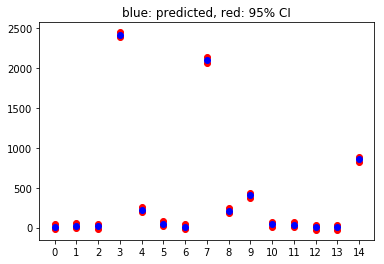

In [45]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

### Dimensionality Reduction: PLSR (Partial Least Squares Regression)

In [46]:
from sklearn.cross_decomposition import PLSRegression

In [70]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

Y_pred_reg = regr.predict(X)
print("R-squared regression: ", regr.score(X,Y))


print("10-k cross validation scores: \n", cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())

R-squared regression:  0.9989995532674184
10-k cross validation scores: 
 [0.99918433 0.99939991 0.99997552 0.99948924 0.99970378 0.99894265
 0.99905906 0.99936564 0.99893903 0.99595589]
Mean CV score:  0.9990015035816853


In [48]:
nyc.columns

Index(['city', 'population', 'violent_crime', 'murder_manslaughter', 'rape',
       'robbery_default', 'aggr_assault', 'property_crime', 'burglary',
       'larceny_theft', 'motor_theft', 'Arson3'],
      dtype='object')

In [116]:
# starting with all variables 

X_pls = nyc[['population', 'violent_crime', 'murder_manslaughter', 'rape',
       'robbery_default', 'aggr_assault',  'burglary',
       'larceny_theft', 'motor_theft', 'Arson3' ]]

y_pls = nyc.property_crime.values.reshape(-1,1)

In [119]:
# Fit a linear model using Partial Least Squares Regression 
# Reduce features to 3 components 

pls = PLSRegression(n_components=3)

# Reduce X to R(X) and fit on y.
pls.fit(X_pls, y_pls)

# Save predicted values 

Y_pred_pls = pls.predict(X_pls)
print('R-squared PLSR: ', pls.score(X_pls, y_pls))


print("10-k cross validation scores: \n", cross_val_score(pls, X_pls, y_pls, cv=10))
print("Mean CV score: ", (cross_val_score(pls, X_pls, y_pls, cv=10)).mean())

# the R-squared is a little less because it's trying to estimate the model from all variables. 

R-squared PLSR:  0.9776743977971222
10-k cross validation scores: 
 [  0.97840145   0.98076495   0.96806595   0.96260841   0.93251845
   0.91607422 -19.29533473   0.97564193   0.98645451   0.98415987]
Mean CV score:  -1.0610644981004276


In [120]:
# pls with the best three features as seen by the multiple linear regression model. 

X_pls = nyc[['burglary', 'larceny_theft', 'motor_theft' ]]

y_pls = nyc.property_crime.values.reshape(-1,1)


pls = PLSRegression(n_components=2) 

# Reduce X to R(X) and fit on y.
pls.fit(X_pls, y_pls)

# Save predicted values 

Y_pred_pls = pls.predict(X_pls)
print('R-squared PLSR: ', pls.score(X_pls, y_pls))

print("10-k cross validation scores: \n", cross_val_score(pls, X_pls, y_pls, cv=10))

print("Mean CV score: ", (cross_val_score(pls, X_pls, y_pls, cv=10)).mean())

R-squared PLSR:  0.9984338015225154
10-k cross validation scores: 
 [0.99933469 0.99760442 0.99683811 0.99902952 0.9981913  0.99712851
 0.99826595 0.998731   0.99862272 0.9968124 ]
Mean CV score:  0.9980558620047999


In [122]:
# Now with pls and one component 

X_pls = nyc[['burglary', 'larceny_theft', 'motor_theft' ]]

y_pls = nyc.property_crime.values.reshape(-1,1)


pls = PLSRegression(n_components=1)

# Reduce X to R(X) and fit on y.
pls.fit(X_pls, y_pls)

# Save predicted values 

Y_pred_pls = pls.predict(X_pls)
print('R-squared PLSR: ', pls.score(X_pls, y_pls))

# the R-squared is .94 because the difference the variability can not be explained by only one dimension. 

print("10-k cross validation scores: \n", cross_val_score(pls, X_pls, y_pls, cv=10))

print("Mean CV score: ", (cross_val_score(pls, X_pls, y_pls, cv=10)).mean())

R-squared PLSR:  0.962730084307109
10-k cross validation scores: 
 [0.96446612 0.96794398 0.95305497 0.93549017 0.88776473 0.86110117
 0.97710588 0.96130756 0.98600104 0.97344002]
Mean CV score:  0.9467675633166456


In [123]:
# trying the lin reg with all features 

X_pls = nyc[['population', 'violent_crime', 'murder_manslaughter', 'rape',
       'robbery_default', 'aggr_assault',  'burglary',
       'larceny_theft', 'motor_theft', 'Arson3' ]]

y_pls = nyc.property_crime.values.reshape(-1,1)

regr = linear_model.LinearRegression()
regr.fit(X_pls, y_pls)

Y_pred_reg = regr.predict(X_pls)
print("R-squared regression: ", regr.score(X_pls,y_pls))

R-squared regression:  0.9995686346583091


In [124]:
# pls with n_component 10 

pls = PLSRegression(n_components=10)

# Reduce X to R(X) and fit on y.
pls.fit(X_pls, y_pls)

# Save predicted values 

Y_pred_pls = pls.predict(X_pls)
print('R-squared PLSR: ', pls.score(X_pls, y_pls))

R-squared PLSR:  0.9995686346583091


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:313: UserWarning: X scores are null at iteration 9
  warnings.warn('X scores are null at iteration %s' % k)


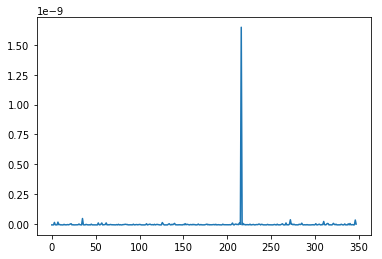

In [125]:
plt.plot(Y_pred_reg - Y_pred_pls)

# difference is virtually none, but if we start decreasing the components we see that the difference increases. 

R-squared PLSR:  0.9992425143876449


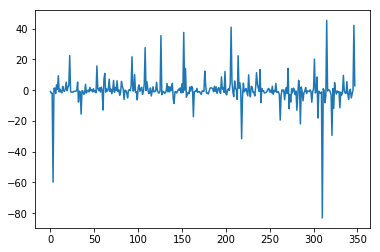

In [138]:
# pls with n_component 5

pls = PLSRegression(n_components=5)

# Reduce X to R(X) and fit on y.
pls.fit(X_pls, y_pls)

# Save predicted values 

Y_pred_pls = pls.predict(X_pls)
print('R-squared PLSR: ', pls.score(X_pls, y_pls))

plt.plot(Y_pred_reg - Y_pred_pls)


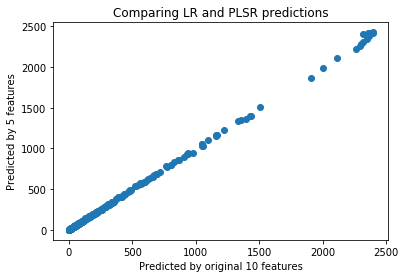

In [139]:
plt.scatter(Y_pred_reg, Y_pred_pls)
plt.xlabel('Predicted by original 10 features')
plt.ylabel('Predicted by 5 features')
plt.title('Comparing LR and PLSR predictions')
plt.show()

In [ ]:
# Here create a loop that fives the plots for the predictions to select the best n_component for the model 

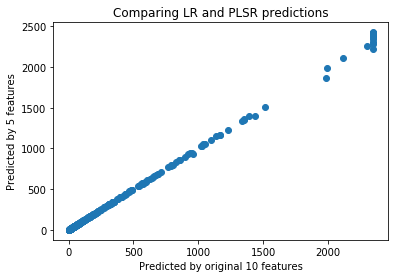

In [140]:
plt.scatter(y_pls, Y_pred_pls)
plt.xlabel('Predicted by original 10 features')
plt.ylabel('Predicted by 5 features')
plt.title('Comparing LR and PLSR predictions')
plt.show()

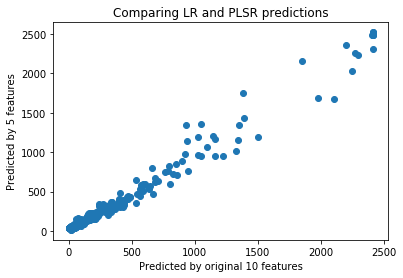

In [51]:
# Comparing the predictions of the two models 

plt.scatter(Y_pred_reg, Y_pred_pls)
plt.xlabel('Predicted by original 10 features')
plt.ylabel('Predicted by 5 features')
plt.title('Comparing LR and PLSR predictions')
plt.show()

### Gradient Descent Algorithm (from Unit 2, lesson 5)

In [295]:
# Trying the crime data for gradient boosting. Using the functions from the lesson, 
# changing the multiple regression to a linear regression


def LR_cost_function (alpha, beta, x, y):
    '''Return the cost for a given line and data.
    
    Alpha and beta are the coeficients that describe the fit line, while x and y are 
    lists or arrays with the x and y value of each data point.
    '''
    error = 0
    n = len(x)
    for i in range(n):
        point_error = (y[i] - (alpha + beta * x[i])) ** 2
        error += point_error
    p = error /n
    return p[0].astype(float)

In [296]:
# Function we'll call each iteration (or step) of the gradient algorithm.
def step (alpha_cur, beta_cur, learning_rate, x, y):
    '''Move downhill from a current cost function to a new, more optimal one.'''
    alpha = 0
    beta = 0
    n = len(x)
    for i in range(n):
        # Partial derivative of the intercept.
        point_alpha = -(2 / n) * (y[i] - ((alpha_cur + beta_cur * x[i])))
        alpha += point_alpha
        
        # Partial derivative of the slope.
        point_beta = -(2 / n) * x[i] * (y[i] - ((alpha_cur + beta_cur * x[i])))
        beta += point_beta
        
    new_alpha = alpha_cur - learning_rate * alpha 
    new_beta = beta_cur - learning_rate * beta
    return new_alpha[0], new_beta[0]   # the original 

In [297]:
# These constants correspond to the decision-points described above.
# How many steps to take.
stop = 50

# How far to move with each step.
learning_rate = .005

# Starting values for intercept and slope 
alpha_start = 0
beta_start = 0


In [298]:
# Fitting a regression model on property crime and larceny_theft which is a good predictor

regr_gb = linear_model.LinearRegression()
Y_gb = nyc.property_crime.values.reshape(-1,1)
X_gb = nyc.larceny_theft.values.reshape(-1,1)
regr_gb.fit(X_gb, Y_gb)

print('\nCoeffiicients: \n', regr_gb.coef_)
print('\nIntercept: \n', regr_gb.intercept_)
print('\nR-squared:')
print(regr_gb.score(X_gb,Y_gb))

print("10-k cross validation scores: \n", cross_val_score(regr_gb, X_gb, Y_gb, cv=10))

print("Mean CV score: ", (cross_val_score(regr_gb, X_gb, Y_gb, cv=10)).mean())

print('\nCoefficients from sklearn: \n', regr_gb.coef_)
print('\nIntercept from sklearn: \n', regr_gb.intercept_)



Coeffiicients: 
 [[1.24063225]]

Intercept: 
 [-1.87162247]

R-squared:
0.9917599909103815
10-k cross validation scores: 
 [0.99454897 0.99342048 0.99103361 0.99424001 0.98429822 0.96762908
 0.99677891 0.99486876 0.99865486 0.97957455]
Mean CV score:  0.989504743422061

Coefficients from sklearn: 
 [[1.24063225]]

Intercept from sklearn: 
 [-1.87162247]


In [299]:
# Now fit an iteratively optimized regression using your custom gradient
# descent algorithm.

# Storing each iteration to inspect later.
all_error=[]

# Provide starting values.
alpha = alpha_start
beta = beta_start

print(alpha, beta)


0 0


In [307]:
stop = 1000
for iter in range(stop):
    
    # Take a step, assigning the results of our step function to feed into
    # the next step.
    alpha, beta = step(alpha, beta, learning_rate, X_gb, Y_gb)
    print(iter)
    print("alpha-beta", alpha, beta)
    # Calculate the error.
    error = LR_cost_function(alpha, beta, X_gb, Y_gb)
    print("error:", error)
    # Store the error to instpect later.
    all_error.append(error)
    
    print("all_Error:", all_error)
print(type(alpha))
print(type(all_error))
#Run the algorithm.
#for iter in range(stop):
#    
#    # Take a step, assigning the results of our step function to feed into
#    # the next step.
#    alpha, beta = step(alpha, beta, learning_rate, X_gb, Y_gb)
#    
#    # Calculate the error.
#    error = LR_cost_function(alpha, beta, X_gb, Y_gb)
#    
#    # Store the error to instpect later.
#    all_error.append(error)
#print(alpha, beta, all_error)

0
alpha-beta 1.6614102375051398e+34 1.5111865698379666e+37
error: 5.374175800339754e+79
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79]
1
alpha-beta -3.9081162043062813e+37 -3.5547467976256076e+40
error: 2.973671850391959e+86
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86]
2
alpha-beta 9.193016824849164e+40 8.361790031382026e+43
error: 1.645410310778171e+93
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.17225690

27
alpha-beta -1.7812411269136295e+125 -1.6201824256705265e+128
error: 6.177368830997663e+261
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.1773688309

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  


error: inf
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

48
alpha-beta 1.1272624161933765e+196 1.0253360582348408e+199
error: inf
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995

error: inf
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

73
alpha-beta -2.184186339265855e+280 -1.986693585612328e+283
error: inf
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in add
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


85
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

115
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

128
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

145
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

178
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

194
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

210
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

243
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

276
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

290
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

300
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

341
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

352
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

362
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

372
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

381
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

391
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

428
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

453
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

465
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

491
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

504
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

531
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

558
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

572
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

586
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+282, 5.790662

616
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+282, 5.790662

654
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

665
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

685
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

706
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0

736
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

766
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

778
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

793
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

809
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

850
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

894
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

909
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0

946
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

969
alpha-beta nan nan
error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275,

error: nan
all_Error: [1997561422765.2578, 1.1053029127777163e+19, 6.115929735077777e+25, 3.384103678005129e+32, 1.8725129619793238e+39, 1.0361103341985874e+46, 5.733069123849214e+52, 3.172256901023586e+59, 1.755292606577764e+66, 9.712492496154383e+72, 5.374175800339754e+79, 2.973671850391959e+86, 1.645410310778171e+93, 9.104485050891717e+99, 5.037749398975656e+106, 2.7875183346469332e+113, 1.5424067079582724e+120, 8.534539210684706e+126, 4.722383477904677e+133, 2.613018132773671e+140, 1.445851188102484e+147, 8.00027229783647e+153, 4.426759639318628e+160, 2.449441740826723e+167, 1.355340097622229e+174, 7.4994507916021695e+180, 4.149642017847137e+187, 2.2961053222143586e+194, 1.270495051868668e+201, 7.029980990881035e+207, 3.8898721139810757e+214, 2.1523678488967397e+221, 1.1909613532829176e+228, 6.589900261428438e+234, 3.646363950926489e+241, 2.0176284215467228e+248, 1.1164065085710385e+255, 6.177368830997663e+261, 3.4180995346421574e+268, 1.891323757470057e+275, 1.0465188387046625e+28

In [301]:
type(all_error)

list


Coefficients from gradient descent algorithm: 
 -6.42432493471554e+33

Intercept from gradient descent algorithm: 
 -7.062952668207188e+30


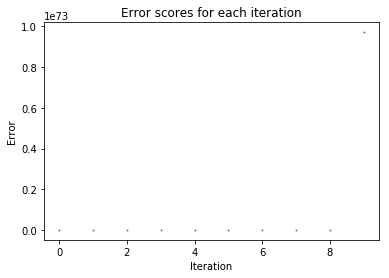

In [306]:
print('\nCoefficients from gradient descent algorithm: \n', beta)
print('\nIntercept from gradient descent algorithm: \n', alpha)

plt.plot(all_error, 'o', ms=.8)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error scores for each iteration')
plt.show()

In [287]:
## Second try on an independent variable that is not a good predictor 

regr_gb1 = linear_model.LinearRegression()
Y_gb1 = nyc.property_crime.values.reshape(-1,1)
X_gb1 = nyc.rape.values.reshape(-1,1)
regr_gb1.fit(X_gb1, Y_gb1)

print('\nCoeffiicients: \n', regr_gb1.coef_)
print('\nIntercept: \n', regr_gb1.intercept_)
print('\nR-squared:')
print(regr_gb1.score(X_gb1,Y_gb1))

print("10-k cross validation scores: \n", cross_val_score(regr_gb1, X_gb1, Y_gb1, cv=10))

print("Mean CV score: ", (cross_val_score(regr_gb1, X_gb1, Y_gb1, cv=10)).mean())


Coeffiicients: 
 [[2.68146665]]

Intercept: 
 [303.37967407]

R-squared:
0.10016919294403559
10-k cross validation scores: 
 [ 4.40229730e-02  1.01639131e-01 -3.30896944e-01  1.70002141e-02
  2.51968532e-02 -2.39756973e-02 -7.23777334e+01  1.24406268e-01
  1.02703302e-01 -2.21414965e-02]
Mean CV score:  -7.233977882188912


In [288]:
print('\nCoefficients from sklearn: \n', regr_gb1.coef_)
print('\nIntercept from sklearn: \n', regr_gb1.intercept_)




Coefficients from sklearn: 
 [[2.68146665]]

Intercept from sklearn: 
 [303.37967407]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]



Coefficients from gradient descent algorithm: 
 nan

Intercept from gradient descent algorithm: 
 nan


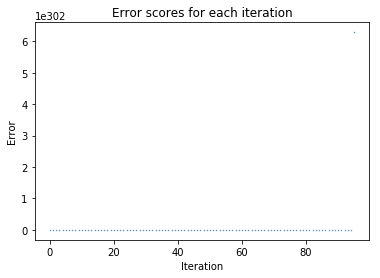

In [309]:
# Now fit an iteratively optimized regression using your custom gradient
# descent algorithm.

stop = 1000
# Storing each iteration to inspect later.
all_error=[]

# Provide starting values.
alpha = alpha_start
beta = beta_start

#Run the algorithm.
for iter in range(stop):
    
    # Take a step, assigning the results of our step function to feed into
    # the next step.
    alpha, beta = step(alpha, beta, learning_rate, X_gb1, Y_gb1)
   # print(iter)
    #print("alpha-beta", alpha, beta)
    # Calculate the error.
    error = LR_cost_function(alpha, beta, X_gb1, Y_gb1)
    #print("error:", error)
    # Store the error to instpect later.
    all_error.append(error)
    #print("all_Error:", all_error)

print('\nCoefficients from gradient descent algorithm: \n', beta)
print('\nIntercept from gradient descent algorithm: \n', alpha)

plt.plot(all_error, 'o', ms=.4)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error scores for each iteration')
plt.show()

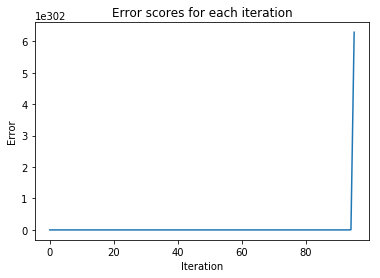

In [310]:
plt.plot(all_error)#, 'o', ms=.4)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error scores for each iteration')
plt.show()

### KNN Classifier  - Unit 3, lesson 1 


Learning by probability: Naive Bayes 
Learning by errors: Regression
Learning by similarity: Nearest Neighbors 



In [207]:
plt.plot?